In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import os

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

from torchvision.transforms import transforms
from torchvision import models

from sklearn.metrics import roc_auc_score

np.random.seed(252525)
torch.manual_seed(252525)

from meanshift import *

device = "cuda"

# Patches in Input Space

In [ ]:
log = []
p = 1
n = 100000

for netname in ["vitb16", "raw", "eff", "res", "vgg"], 
    
    s = 4 if netname == "vitb16" else 2
    L = 7 if netname == "vitb16" else 5
    blocks = [L, L+1] if netname == "vgg" or  netname == "eff" else [L]
    
    for P in [16, 24, 30, 32]:
    
        for A in [32]:
            
            if P > A:
                continue

            r = int( (A - P)/s + 1 )

            for run in range(3):
                
                if netname != "raw":
                    net, layer_map = get_fmap(netname)
                    net = net.to(device)
                    net = net.eval()


                for clazz in range(0, 10):
                    
                    if netname == "raw":
                        X, X_valid, X_test = Cifar10_OneClass(train_classes=[clazz], balance=False, fold=run, download=False)[0]
                        X, X_valid, X_test,  mean, std = preprocess(X, X_valid, X_test)
                    else:
                        transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                        ])
                        X, X_valid, X_test = Cifar10_OneClass(train_classes=[clazz], balance=False, fold=run, download=False, transform=transform)[0]
                    
                    X, X_valid, X_test = asreshape(X, X_valid, X_test, shape=(3, 32, 32))
                        
                    if netname == "raw":
                        net, layer_map = get_pca(X, 0.9, P, s)
                        net = net.to(device)
                        net = net.eval()

                    if netname == "vitb16":
                        X = patches_to_feature_space_vit(X, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
                        X_valid = patches_to_feature_space_vit(X_valid, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
                        X_test = patches_to_feature_space_vit(X_test, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
                    else:
                        X = patches_to_feature_space(X, net, P, s, blocks=blocks, layer_map=layer_map, debug=True)
                        X_valid = patches_to_feature_space(X_valid, net, P, s, blocks=blocks, layer_map=layer_map)
                        X_test = patches_to_feature_space(X_test, net, P, s, blocks=blocks, layer_map=layer_map)

                    print(X.shape)

                    mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
                    s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                    s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                    auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    log.append(pd.DataFrame(np.asarray([run, netname, clazz, Cifar10_OneClass.CLASSES[clazz], A, P, s, p, blocks[0], n, r, auc_local])[:, None].T, columns=["run", "fmap", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc_local"])) 

                    display(log[-1])
                    
                    torch.save(log, "backup_vitb16.log")

(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,0,plane,32,16,4,1,7,100000,5,0.825743


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,1,car,32,16,4,1,7,100000,5,0.840677


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,2,bird,32,16,4,1,7,100000,5,0.7173450000000001


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,3,cat,32,16,4,1,7,100000,5,0.83554


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,4,deer,32,16,4,1,7,100000,5,0.8744909999999999


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,5,dog,32,16,4,1,7,100000,5,0.8231729999999999


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,6,frog,32,16,4,1,7,100000,5,0.893332


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,7,horse,32,16,4,1,7,100000,5,0.8820899999999999


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,8,ship,32,16,4,1,7,100000,5,0.8795879999999999


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,9,truck,32,16,4,1,7,100000,5,0.909755


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,0,plane,32,16,4,1,7,100000,5,0.8038129999999999


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,1,car,32,16,4,1,7,100000,5,0.862067


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,2,bird,32,16,4,1,7,100000,5,0.720294


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,3,cat,32,16,4,1,7,100000,5,0.82159


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,4,deer,32,16,4,1,7,100000,5,0.866139


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,5,dog,32,16,4,1,7,100000,5,0.821898


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,6,frog,32,16,4,1,7,100000,5,0.896529


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,7,horse,32,16,4,1,7,100000,5,0.852662


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,8,ship,32,16,4,1,7,100000,5,0.8812839999999998


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,9,truck,32,16,4,1,7,100000,5,0.920236


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,0,plane,32,16,4,1,7,100000,5,0.81575


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,1,car,32,16,4,1,7,100000,5,0.864905


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,2,bird,32,16,4,1,7,100000,5,0.7308950000000001


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,3,cat,32,16,4,1,7,100000,5,0.8124790000000001


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,4,deer,32,16,4,1,7,100000,5,0.866769


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,5,dog,32,16,4,1,7,100000,5,0.8246770000000001


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,6,frog,32,16,4,1,7,100000,5,0.896389


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,7,horse,32,16,4,1,7,100000,5,0.869531


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,8,ship,32,16,4,1,7,100000,5,0.8899520000000001


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,9,truck,32,16,4,1,7,100000,5,0.913044


In [24]:
for P in [30, 31, 32]:
    for netname in ["eff", "res", "vgg"]: 
        print(P, netname)
        log_ = pd.concat(log).drop(columns=["class_name"])
        log_ = log_[(log_["P"] == str(P))]
        log_ = log_[(log_["fmap"] == netname)]
        log_ = log_.drop(columns=["fmap"]).astype(np.float32)

        for clazz in range(10):
            auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc_local"]
            print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

        avg = log_.groupby("run").mean()["auc_local"].mean()
        std = log_.groupby("run").mean()["auc_local"].std()
        print(avg, std)

30 eff
class=plane      	auc: 0.767 ± 0.006
class=car        	auc: 0.880 ± 0.013
class=bird       	auc: 0.629 ± 0.014
class=cat        	auc: 0.625 ± 0.001
class=deer       	auc: 0.822 ± 0.016
class=dog        	auc: 0.719 ± 0.002
class=frog       	auc: 0.888 ± 0.005
class=horse      	auc: 0.851 ± 0.004
class=ship       	auc: 0.811 ± 0.019
class=truck      	auc: 0.876 ± 0.010
0.7867996692657471 0.007557608652859926
30 res
class=plane      	auc: 0.855 ± 0.004
class=car        	auc: 0.907 ± 0.010
class=bird       	auc: 0.731 ± 0.002
class=cat        	auc: 0.636 ± 0.005
class=deer       	auc: 0.851 ± 0.009
class=dog        	auc: 0.750 ± 0.008
class=frog       	auc: 0.922 ± 0.005
class=horse      	auc: 0.872 ± 0.004
class=ship       	auc: 0.874 ± 0.015
class=truck      	auc: 0.914 ± 0.008
0.8311695456504822 0.0030249543488025665
30 vgg
class=plane      	auc: 0.808 ± 0.001
class=car        	auc: 0.705 ± 0.022
class=bird       	auc: 0.658 ± 0.006
class=cat        	auc: 0.599 ± 0.006
class=deer

In [4]:
net, layer_map = get_fmap("vitb16")
net = net.to(device)  

In [8]:
A = 32
P = 30
s = 1
p = 1
blocks = [7]
shape = (3, 32, 32)

netname = "vit16"
log = []

for P in [16, 32]
    for A in [24]:
        if P > A:
            continue
        
        for run in range(3):
                
            for clazz in range(0, 10):

                transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                        ])

                X_, X_valid_, X_test_ = Cifar10_OneClass(train_classes=[clazz], balance=False, transform=transform, fold=run, download=False)[0]

                X = X_.reshape(len(X_), *shape)
                X_valid = X_valid_.reshape((len(X_valid_), *shape))
                X_test = X_test_.reshape((len(X_test_), *shape))

                X = patches_to_feature_space_vit(X, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
                X_valid = patches_to_feature_space_vit(X_valid, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
                X_test = patches_to_feature_space_vit(X_test, net, P=P, s=s, blocks=blocks, layer_map=layer_map)

                print(X.shape)

                mu, means, cov, T = estimate_statistics(X, mode="ledoit", BSZ=(p, p), rho=r)
                s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                mu, cov, T = estimate_global_statistics(X, mode="ledoit", BSZ=(p, p))

                s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                log.append(pd.DataFrame(np.asarray([run, netname, clazz, Cifar10_OneClass.CLASSES[clazz], A, P, s, p, blocks[0], len(X), r, auc, auc_local])[:, None].T, columns=["run", "fmap", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

                display(log[-1])


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,0,plane,32,30,1,1,7,5000,3,0.947352,0.947352


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,1,car,32,30,1,1,7,5000,3,0.976886,0.976886


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,2,bird,32,30,1,1,7,5000,3,0.9439620000000001,0.9439620000000001


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,3,cat,32,30,1,1,7,5000,3,0.945381,0.945381


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,4,deer,32,30,1,1,7,5000,3,0.959977,0.959977


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,5,dog,32,30,1,1,7,5000,3,0.970844,0.970844


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,6,frog,32,30,1,1,7,5000,3,0.973278,0.973278


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,7,horse,32,30,1,1,7,5000,3,0.9740449999999999,0.9740449999999999


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,8,ship,32,30,1,1,7,5000,3,0.973347,0.973348


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,9,truck,32,30,1,1,7,5000,3,0.971746,0.971746


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,vit16,0,plane,32,30,1,1,7,5000,3,0.952321,0.952321


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,vit16,1,car,32,30,1,1,7,5000,3,0.980308,0.980308


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,vit16,2,bird,32,30,1,1,7,5000,3,0.942511,0.942511


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,vit16,3,cat,32,30,1,1,7,5000,3,0.932428,0.932428


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,vit16,4,deer,32,30,1,1,7,5000,3,0.956262,0.956262


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,vit16,5,dog,32,30,1,1,7,5000,3,0.970588,0.970588


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,vit16,6,frog,32,30,1,1,7,5000,3,0.9777180000000001,0.9777180000000001


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,vit16,7,horse,32,30,1,1,7,5000,3,0.975063,0.975063


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,vit16,8,ship,32,30,1,1,7,5000,3,0.983175,0.983175


Files already downloaded and verified
Files already downloaded and verified
(5000, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,vit16,9,truck,32,30,1,1,7,5000,3,0.980185,0.980185


Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

In [7]:
# P = 32, s=1

for netname in ["vit16"]: 
    
    log_ = pd.concat(log).drop(columns=["class_name"])
    log_ = log_[(log_["fmap"] == netname)]
    log_ = log_.drop(columns=["fmap"]).astype(np.float32)

    for clazz in range(10):
        auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc_local"]
        print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

    avg = log_.groupby("run").mean()["auc_local"].mean()
    std = log_.groupby("run").mean()["auc_local"].std()
    print(avg, std)

class=plane      	auc: 0.948 ± 0.005
class=car        	auc: 0.979 ± 0.003
class=bird       	auc: 0.942 ± 0.005
class=cat        	auc: 0.923 ± 0.008
class=deer       	auc: 0.955 ± 0.005
class=dog        	auc: 0.970 ± 0.006
class=frog       	auc: 0.970 ± 0.003
class=horse      	auc: 0.972 ± 0.002
class=ship       	auc: 0.976 ± 0.005
class=truck      	auc: 0.975 ± 0.004
0.9610335230827332 0.0019934598822146654


In [9]:
# P = 30, s=1

for netname in ["vit16"]: 
    
    log_ = pd.concat(log).drop(columns=["class_name"])
    log_ = log_[(log_["fmap"] == netname)]
    log_ = log_.drop(columns=["fmap"]).astype(np.float32)

    for clazz in range(10):
        auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc_local"]
        print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

    avg = log_.groupby("run").mean()["auc_local"].mean()
    std = log_.groupby("run").mean()["auc_local"].std()
    print(avg, std)

class=plane      	auc: 0.950 ± 0.004
class=car        	auc: 0.979 ± 0.002
class=bird       	auc: 0.943 ± 0.001
class=cat        	auc: 0.939 ± 0.009
class=deer       	auc: 0.958 ± 0.003
class=dog        	auc: 0.971 ± 0.000
class=frog       	auc: 0.975 ± 0.003
class=horse      	auc: 0.975 ± 0.001
class=ship       	auc: 0.978 ± 0.007
class=truck      	auc: 0.976 ± 0.006
0.9643688797950745 0.0009715691558085382


In [33]:
# P = 31, s=1

for netname in ["vit16"]: 
    
    log_ = pd.concat(log).drop(columns=["class_name"])
    log_ = log_[(log_["fmap"] == netname)]
    log_ = log_.drop(columns=["fmap"]).astype(np.float32)

    for clazz in range(10):
        auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc_local"]
        print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

    avg = log_.groupby("run").mean()["auc_local"].mean()
    std = log_.groupby("run").mean()["auc_local"].std()
    print(avg, std)

class=plane      	auc: 0.948 ± nan
class=car        	auc: 0.976 ± nan
class=bird       	auc: 0.946 ± nan
class=cat        	auc: 0.927 ± nan
class=deer       	auc: 0.952 ± nan
class=dog        	auc: 0.970 ± nan
class=frog       	auc: 0.969 ± nan
class=horse      	auc: 0.973 ± nan
class=ship       	auc: 0.975 ± nan
class=truck      	auc: 0.977 ± nan
0.9611910581588745 nan


# Patches in Feature map

In [10]:
#log = []

receptive_fields = [6, 14, 14, 30, 30]

for j, layers in enumerate([[2], [3], [4], [5]]):

    for run in range(2):

        for clazz in [0, 2, 3, 8]:
         
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

            test_classes = [0,1,2,3,4,5,6,7,8,9]
            test_classes.remove(clazz)
            X_, X_valid_, X_test_ = Cifar10_OneClass(train_classes=[clazz], test_classes=test_classes, balance=False, fold=run, transform=transform)[0]
            
            X, X_valid, X_test =  X_, X_valid_, X_test_
            X = X.reshape(len(X), 3, 32, 32)
            X_valid = X_valid.reshape((len(X_valid), 3, 32, 32))
            X_test = X_test.reshape((len(X_test), 3, 32, 32))
            
            model = DeepMeanShift(features="vgg", blocks=layers, receptive_field=receptive_fields[j])
            model = model.fit(X, verbose=True, A=32, P=32, s=2)
            
            auc = model.evaluate(X_valid, X_test)
            log.append(pd.DataFrame(np.asarray([run, clazz, layers[0], auc])[:, None].T, columns=["run", "class", "layers", "auc_local"])) 

            display(log[-1])
#pd.concat(log).to_csv("./experiments/Eff-Net-layers_L.csv")

Files already downloaded and verified
Files already downloaded and verified
A=32, P=32, s=2, F=1, rho=1, T=4, fmap=(5000, 512, 2, 2), means=(1, 512, 2, 2), mu=(512,), cov=(512, 512)


,run,class,layers,auc_local
0,0.0,0.0,6.0,0.832686


Files already downloaded and verified
Files already downloaded and verified
A=32, P=32, s=2, F=1, rho=1, T=4, fmap=(5000, 512, 2, 2), means=(1, 512, 2, 2), mu=(512,), cov=(512, 512)


,run,class,layers,auc_local
0,0.0,2.0,6.0,0.689017


Files already downloaded and verified
Files already downloaded and verified
A=32, P=32, s=2, F=1, rho=1, T=4, fmap=(5000, 512, 2, 2), means=(1, 512, 2, 2), mu=(512,), cov=(512, 512)


,run,class,layers,auc_local
0,0.0,3.0,6.0,0.660374


Files already downloaded and verified
Files already downloaded and verified
A=32, P=32, s=2, F=1, rho=1, T=4, fmap=(5000, 512, 2, 2), means=(1, 512, 2, 2), mu=(512,), cov=(512, 512)


,run,class,layers,auc_local
0,0.0,8.0,6.0,0.880862


Files already downloaded and verified
Files already downloaded and verified
A=32, P=32, s=2, F=1, rho=1, T=4, fmap=(5000, 512, 2, 2), means=(1, 512, 2, 2), mu=(512,), cov=(512, 512)


,run,class,layers,auc_local
0,1.0,0.0,6.0,0.838118


Files already downloaded and verified
Files already downloaded and verified
A=32, P=32, s=2, F=1, rho=1, T=4, fmap=(5000, 512, 2, 2), means=(1, 512, 2, 2), mu=(512,), cov=(512, 512)


,run,class,layers,auc_local
0,1.0,2.0,6.0,0.673604


Files already downloaded and verified
Files already downloaded and verified
A=32, P=32, s=2, F=1, rho=1, T=4, fmap=(5000, 512, 2, 2), means=(1, 512, 2, 2), mu=(512,), cov=(512, 512)


,run,class,layers,auc_local
0,1.0,3.0,6.0,0.6394


Files already downloaded and verified
Files already downloaded and verified
A=32, P=32, s=2, F=1, rho=1, T=4, fmap=(5000, 512, 2, 2), means=(1, 512, 2, 2), mu=(512,), cov=(512, 512)


,run,class,layers,auc_local
0,1.0,8.0,6.0,0.895173


In [11]:
pd.concat(log).to_csv("./experiments/VGG-Net-layers_L.csv")

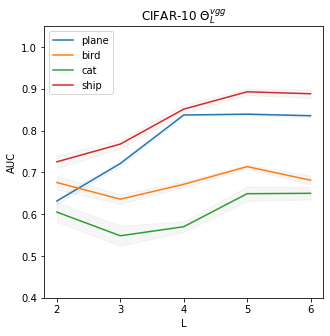

In [3]:
import tikzplotlib
plt.rcParams["figure.figsize"] = (5, 5)

x = [2, 3, 4, 5, 6]
xticks = [2, 3, 4, 5, 6]

colors = ["b", "g", "r", "orange", "pink"]
dat = pd.read_csv("./experiments/VGG-Net-layers_L.csv")

for cls in [0, 2, 3, 8]:
    log_ = dat[dat["class"] == cls]
    mean = log_.groupby("layers").mean()["auc_local"]
    s = log_.groupby("layers").std()["auc_local"]
    plt.plot(x, mean, label=Cifar10_OneClass.CLASSES[cls])
    plt.fill_between(x, mean-s, mean+s, color="grey", alpha=.07)

plt.title(r"CIFAR-10 $\Theta^{vgg}_L$")
plt.xticks(xticks)
plt.ylim(0.4, 1.05)
plt.ylabel("AUC")
plt.xlabel(r"L")
plt.legend()

tikzplotlib.save(f"tex/CIFAR_Block_L.tex")
plt.show()

In [6]:
log = []
layers = [5, 6] 
p = 1
r = 2
n = 5000

for run in range(1):

    for clazz in range(0, 10):
          
        net, layer_map = get_fmap("vgg")
        net = net.to(device)
       
        scores_in = []
        scores_out = []
        
        for rot in range(1):
        
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

            test_classes = [0,1,2,3,4,5,6,7,8,9]
            test_classes.remove(clazz)
            X_, X_valid_, X_test_ = Cifar10_OneClass(train_classes=[clazz], test_classes=test_classes, balance=False, fold=run, transform=transform)[0]
            
            X, X_valid, X_test =  X_, X_valid_, X_test_
            X = X.reshape(len(X), 3, 32, 32)
            X_valid = X_valid.reshape((len(X_valid), 3, 32, 32))
            X_test = X_test.reshape((len(X_test), 3, 32, 32))

            X = concat_features(X, net, blocks=layers, fmap_pool=False, layer_map=layer_map)
            X_valid = concat_features(X_valid, net, blocks=layers, fmap_pool=False, layer_map=layer_map)
            X_test = concat_features(X_test, net, blocks=layers, fmap_pool=False, layer_map=layer_map)
            
            print(X.shape)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            scores_in.append(s_in)
            scores_out.append(s_out)
            
        auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([np.asarray(scores_in).sum(0), np.asarray(scores_out).sum(0)]))

        log.append(pd.DataFrame(np.asarray([run, clazz, p, r, layers[0], n, auc])[:, None].T, columns=["run", "class", "BSZ", "rho", "layers", "n_samples", "auc"])) 

        display(pd.concat(log))
    

Files already downloaded and verified
Files already downloaded and verified
(5000, 1024, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,1.0,2.0,5.0,5000.0,0.85162


Files already downloaded and verified
Files already downloaded and verified
(5000, 1024, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,1.0,2.0,5.0,5000.0,0.851620
0,0.0,1.0,1.0,2.0,5.0,5000.0,0.888376


Files already downloaded and verified
Files already downloaded and verified
(5000, 1024, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,1.0,2.0,5.0,5000.0,0.851620
0,0.0,1.0,1.0,2.0,5.0,5000.0,0.888376
0,0.0,2.0,1.0,2.0,5.0,5000.0,0.728127


Files already downloaded and verified
Files already downloaded and verified
(5000, 1024, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,1.0,2.0,5.0,5000.0,0.851620
0,0.0,1.0,1.0,2.0,5.0,5000.0,0.888376
0,0.0,2.0,1.0,2.0,5.0,5000.0,0.728127
0,0.0,3.0,1.0,2.0,5.0,5000.0,0.683690


Files already downloaded and verified
Files already downloaded and verified
(5000, 1024, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,1.0,2.0,5.0,5000.0,0.851620
0,0.0,1.0,1.0,2.0,5.0,5000.0,0.888376
0,0.0,2.0,1.0,2.0,5.0,5000.0,0.728127
0,0.0,3.0,1.0,2.0,5.0,5000.0,0.683690
0,0.0,4.0,1.0,2.0,5.0,5000.0,0.856922


Files already downloaded and verified
Files already downloaded and verified
(5000, 1024, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,1.0,2.0,5.0,5000.0,0.851620
0,0.0,1.0,1.0,2.0,5.0,5000.0,0.888376
0,0.0,2.0,1.0,2.0,5.0,5000.0,0.728127
0,0.0,3.0,1.0,2.0,5.0,5000.0,0.683690
0,0.0,4.0,1.0,2.0,5.0,5000.0,0.856922
0,0.0,5.0,1.0,2.0,5.0,5000.0,0.759809


Files already downloaded and verified
Files already downloaded and verified
(5000, 1024, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,1.0,2.0,5.0,5000.0,0.851620
0,0.0,1.0,1.0,2.0,5.0,5000.0,0.888376
0,0.0,2.0,1.0,2.0,5.0,5000.0,0.728127
0,0.0,3.0,1.0,2.0,5.0,5000.0,0.683690
0,0.0,4.0,1.0,2.0,5.0,5000.0,0.856922
0,0.0,5.0,1.0,2.0,5.0,5000.0,0.759809
0,0.0,6.0,1.0,2.0,5.0,5000.0,0.884812


Files already downloaded and verified
Files already downloaded and verified
(5000, 1024, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,1.0,2.0,5.0,5000.0,0.851620
0,0.0,1.0,1.0,2.0,5.0,5000.0,0.888376
0,0.0,2.0,1.0,2.0,5.0,5000.0,0.728127
0,0.0,3.0,1.0,2.0,5.0,5000.0,0.683690
0,0.0,4.0,1.0,2.0,5.0,5000.0,0.856922
0,0.0,5.0,1.0,2.0,5.0,5000.0,0.759809
0,0.0,6.0,1.0,2.0,5.0,5000.0,0.884812
0,0.0,7.0,1.0,2.0,5.0,5000.0,0.865788


Files already downloaded and verified
Files already downloaded and verified
(5000, 1024, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,1.0,2.0,5.0,5000.0,0.851620
0,0.0,1.0,1.0,2.0,5.0,5000.0,0.888376
0,0.0,2.0,1.0,2.0,5.0,5000.0,0.728127
0,0.0,3.0,1.0,2.0,5.0,5000.0,0.683690
0,0.0,4.0,1.0,2.0,5.0,5000.0,0.856922
0,0.0,5.0,1.0,2.0,5.0,5000.0,0.759809
0,0.0,6.0,1.0,2.0,5.0,5000.0,0.884812
0,0.0,7.0,1.0,2.0,5.0,5000.0,0.865788
0,0.0,8.0,1.0,2.0,5.0,5000.0,0.894706


Files already downloaded and verified
Files already downloaded and verified
(5000, 1024, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,1.0,2.0,5.0,5000.0,0.851620
0,0.0,1.0,1.0,2.0,5.0,5000.0,0.888376
0,0.0,2.0,1.0,2.0,5.0,5000.0,0.728127
0,0.0,3.0,1.0,2.0,5.0,5000.0,0.683690
0,0.0,4.0,1.0,2.0,5.0,5000.0,0.856922
0,0.0,5.0,1.0,2.0,5.0,5000.0,0.759809
0,0.0,6.0,1.0,2.0,5.0,5000.0,0.884812
0,0.0,7.0,1.0,2.0,5.0,5000.0,0.865788
0,0.0,8.0,1.0,2.0,5.0,5000.0,0.894706
0,0.0,9.0,1.0,2.0,5.0,5000.0,0.913716


In [7]:
log_ = pd.concat(log) # P=1

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.852 ± nan
class=car        	auc: 0.888 ± nan
class=bird       	auc: 0.728 ± nan
class=cat        	auc: 0.684 ± nan
class=deer       	auc: 0.857 ± nan
class=dog        	auc: 0.760 ± nan
class=frog       	auc: 0.885 ± nan
class=horse      	auc: 0.866 ± nan
class=ship       	auc: 0.895 ± nan
class=truck      	auc: 0.914 ± nan
0.8327566


In [9]:
log = []
layers = [5, 6] 
p = 1
r = 2
n = 5000

for run in range(1):

    for clazz in range(0, 10):
          
        net, layer_map = get_fmap("vgg")
        net = net.to(device)
       
        scores_in = []
        scores_out = []
        
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        test_classes = [0,1,2,3,4,5,6,7,8,9]
        test_classes.remove(clazz)
        X_, X_valid_, X_test_ = Cifar10_OneClass(train_classes=[clazz], test_classes=test_classes, balance=False, fold=run, transform=transform)[0]

        X, X_valid, X_test =  X_, X_valid_, X_test_
        X = X.reshape(len(X), 3, 32, 32)
        X_valid = X_valid.reshape((len(X_valid), 3, 32, 32))
        X_test = X_test.reshape((len(X_test), 3, 32, 32))

        X = concat_features(X, net, blocks=layers, fmap_pool=False, layer_map=layer_map)
        X_valid = concat_features(X_valid, net, blocks=layers, fmap_pool=False, layer_map=layer_map)
        X_test = concat_features(X_test, net, blocks=layers, fmap_pool=False, layer_map=layer_map)

        print(X.shape)

        mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
        s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
        s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

        scores_in.append(s_in)
        scores_out.append(s_out)

        auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([np.asarray(scores_in).sum(0), np.asarray(scores_out).sum(0)]))
        
        mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

        s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
        s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

        auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

        log.append(pd.DataFrame(np.asarray([run, clazz, p, r, layers[0], n, auc, auc_local])[:, None].T, columns=["run", "class", "BSZ", "rho", "layers", "n_samples", "auc", "auc_local"])) 

        display(pd.concat(log))
    
        break
    break


Files already downloaded and verified
Files already downloaded and verified
(5000, 1024, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc,auc_local
0,0.0,0.0,1.0,2.0,5.0,5000.0,0.851621,0.85162


In [8]:
log = []
L = 5
P = 31
s = 1
p = 1
n = 100000

for netname in ["vgg", "eff", "res"]:
    
    blocks = [L, L+1] if netname == "vgg" or  netname == "eff" else [L]

    for A in [32]:

        r = int( (A - P)/s + 1 )

        for run in range(1):
            run = -1

            net, layer_map = get_fmap(netname)
            net = net.to(device)

            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

            for clazz in range(0, 10):

                test_classes = [0,1,2,3,4,5,6,7,8,9]
                test_classes.remove(clazz)
                X_, X_valid_, X_test_ = Cifar10_OneClass(train_classes=[clazz], test_classes=test_classes, balance=False, fold=run, transform=transform)[0]
                X, X_valid, X_test =  X_, X_valid_, X_test_

                X = X.reshape(len(X), 3, 32, 32)
                X_valid = X_valid.reshape((len(X_valid), 3, 32, 32))
                X_test = X_test.reshape((len(X_test), 3, 32, 32))
                
                X = patches_to_feature_space(X, net, P, s, blocks=blocks, layer_map=layer_map, debug=True)
                X_valid = patches_to_feature_space(X_valid, net, P, s, blocks=blocks, layer_map=layer_map)
                X_test = patches_to_feature_space(X_test, net, P, s, blocks=blocks, layer_map=layer_map)
                
                print(X.shape)
                
                mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
                s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

                s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                log.append(pd.DataFrame(np.asarray([run, netname, clazz, Cifar10_OneClass.CLASSES[clazz], A, P, s, p, blocks[0], n, r, auc, auc_local])[:, None].T, columns=["run", "fmap", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

                display(log[-1])

                break
            break
        break
    break

Files already downloaded and verified
Files already downloaded and verified
Fmap: (5000, 1024, 1, 1)
(5000, 1024, 1, 1)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,vgg,0,plane,32,30,14,1,5,100000,1,0.8102041111111112,0.8102043333333333


In [4]:
log = []
layers = [5, 6] 
p = 2
r = 1
n = 5000

for run in range(2):

    for clazz in range(0, 10):
          
        #net = VGG('VGG19', True)
        #state = torch.load(f"__cache__/checkpoint_cifar_raw/ckpt_{clazz}.pth")["net"]
        #net.load_state_dict(state)
        
        #net = models.vgg19(pretrained=True)
        
        #net = torch.hub.load('pytorch/vision:v0.9.0', 'wide_resnet50_2', pretrained=True)
        #net = nn.Sequential(net.conv1, net.bn1, net.relu, net.maxpool, net.layer1, net.layer2, net.layer3, net.layer4)
        
        net = models.efficientnet_b4(pretrained=True)
        net = net.features
        
        net = net.to(device)
       
        scores_in = []
        scores_out = []
        
        for rot in range(1):
        
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

            test_classes = [0,1,2,3,4,5,6,7,8,9]
            test_classes.remove(clazz)
            X_, X_valid_, X_test_ = Cifar10_OneClass(train_classes=[clazz], test_classes=test_classes, balance=False, fold=run, transform=transform)[0]
            
            X, X_valid, X_test =  X_, X_valid_, X_test_
            X = X.reshape(len(X), 3, 32, 32)
            X_valid = X_valid.reshape((len(X_valid), 3, 32, 32))
            X_test = X_test.reshape((len(X_test), 3, 32, 32))

            X = concat_features(X, net, layers=layers, fmap_pool=False)
            X_valid = concat_features(X_valid, net, layers=layers, fmap_pool=False)
            X_test = concat_features(X_test, net, layers=layers, fmap_pool=False)
            
            print(X.shape)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            scores_in.append(s_in)
            scores_out.append(s_out)
            
        auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([np.asarray(scores_in).sum(0), np.asarray(scores_out).sum(0)]))

        log.append(pd.DataFrame(np.asarray([run, clazz, p, r, layers[0], n, auc])[:, None].T, columns=["run", "class", "BSZ", "rho", "layers", "n_samples", "auc"])) 

        display(pd.concat(log))
        

Files already downloaded and verified
Files already downloaded and verified
(5000, 272, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,2.0,1.0,5.0,5000.0,0.648667


Files already downloaded and verified
Files already downloaded and verified
(5000, 272, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,2.0,1.0,5.0,5000.0,0.648667
0,0.0,1.0,2.0,1.0,5.0,5000.0,0.631448


Files already downloaded and verified
Files already downloaded and verified
(5000, 272, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,2.0,1.0,5.0,5000.0,0.648667
0,0.0,1.0,2.0,1.0,5.0,5000.0,0.631448
0,0.0,2.0,2.0,1.0,5.0,5000.0,0.571194


Files already downloaded and verified
Files already downloaded and verified
(5000, 272, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,2.0,1.0,5.0,5000.0,0.648667
0,0.0,1.0,2.0,1.0,5.0,5000.0,0.631448
0,0.0,2.0,2.0,1.0,5.0,5000.0,0.571194
0,0.0,3.0,2.0,1.0,5.0,5000.0,0.514782


Files already downloaded and verified
Files already downloaded and verified
(5000, 272, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,2.0,1.0,5.0,5000.0,0.648667
0,0.0,1.0,2.0,1.0,5.0,5000.0,0.631448
0,0.0,2.0,2.0,1.0,5.0,5000.0,0.571194
0,0.0,3.0,2.0,1.0,5.0,5000.0,0.514782
0,0.0,4.0,2.0,1.0,5.0,5000.0,0.527112


Files already downloaded and verified
Files already downloaded and verified
(5000, 272, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,2.0,1.0,5.0,5000.0,0.648667
0,0.0,1.0,2.0,1.0,5.0,5000.0,0.631448
0,0.0,2.0,2.0,1.0,5.0,5000.0,0.571194
0,0.0,3.0,2.0,1.0,5.0,5000.0,0.514782
0,0.0,4.0,2.0,1.0,5.0,5000.0,0.527112
0,0.0,5.0,2.0,1.0,5.0,5000.0,0.541187


Files already downloaded and verified
Files already downloaded and verified
(5000, 272, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,2.0,1.0,5.0,5000.0,0.648667
0,0.0,1.0,2.0,1.0,5.0,5000.0,0.631448
0,0.0,2.0,2.0,1.0,5.0,5000.0,0.571194
0,0.0,3.0,2.0,1.0,5.0,5000.0,0.514782
0,0.0,4.0,2.0,1.0,5.0,5000.0,0.527112
0,0.0,5.0,2.0,1.0,5.0,5000.0,0.541187
0,0.0,6.0,2.0,1.0,5.0,5000.0,0.580703


Files already downloaded and verified
Files already downloaded and verified
(5000, 272, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,2.0,1.0,5.0,5000.0,0.648667
0,0.0,1.0,2.0,1.0,5.0,5000.0,0.631448
0,0.0,2.0,2.0,1.0,5.0,5000.0,0.571194
0,0.0,3.0,2.0,1.0,5.0,5000.0,0.514782
0,0.0,4.0,2.0,1.0,5.0,5000.0,0.527112
0,0.0,5.0,2.0,1.0,5.0,5000.0,0.541187
0,0.0,6.0,2.0,1.0,5.0,5000.0,0.580703
0,0.0,7.0,2.0,1.0,5.0,5000.0,0.599427


Files already downloaded and verified
Files already downloaded and verified
(5000, 272, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,2.0,1.0,5.0,5000.0,0.648667
0,0.0,1.0,2.0,1.0,5.0,5000.0,0.631448
0,0.0,2.0,2.0,1.0,5.0,5000.0,0.571194
0,0.0,3.0,2.0,1.0,5.0,5000.0,0.514782
0,0.0,4.0,2.0,1.0,5.0,5000.0,0.527112
0,0.0,5.0,2.0,1.0,5.0,5000.0,0.541187
0,0.0,6.0,2.0,1.0,5.0,5000.0,0.580703
0,0.0,7.0,2.0,1.0,5.0,5000.0,0.599427
0,0.0,8.0,2.0,1.0,5.0,5000.0,0.644498


Files already downloaded and verified
Files already downloaded and verified
(5000, 272, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,2.0,1.0,5.0,5000.0,0.648667
0,0.0,1.0,2.0,1.0,5.0,5000.0,0.631448
0,0.0,2.0,2.0,1.0,5.0,5000.0,0.571194
0,0.0,3.0,2.0,1.0,5.0,5000.0,0.514782
0,0.0,4.0,2.0,1.0,5.0,5000.0,0.527112
0,0.0,5.0,2.0,1.0,5.0,5000.0,0.541187
0,0.0,6.0,2.0,1.0,5.0,5000.0,0.580703
0,0.0,7.0,2.0,1.0,5.0,5000.0,0.599427
0,0.0,8.0,2.0,1.0,5.0,5000.0,0.644498
0,0.0,9.0,2.0,1.0,5.0,5000.0,0.565718


Files already downloaded and verified
Files already downloaded and verified
(5000, 272, 2, 2)


,run,class,BSZ,rho,layers,n_samples,auc
0,0.0,0.0,2.0,1.0,5.0,5000.0,0.648667
0,0.0,1.0,2.0,1.0,5.0,5000.0,0.631448
0,0.0,2.0,2.0,1.0,5.0,5000.0,0.571194
0,0.0,3.0,2.0,1.0,5.0,5000.0,0.514782
0,0.0,4.0,2.0,1.0,5.0,5000.0,0.527112
0,0.0,5.0,2.0,1.0,5.0,5000.0,0.541187
0,0.0,6.0,2.0,1.0,5.0,5000.0,0.580703
0,0.0,7.0,2.0,1.0,5.0,5000.0,0.599427
0,0.0,8.0,2.0,1.0,5.0,5000.0,0.644498
0,0.0,9.0,2.0,1.0,5.0,5000.0,0.565718


Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

In [5]:
log_ = pd.concat(log) # eff [5,6]  p2
 
s
for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.642 ± 0.009
class=car        	auc: 0.631 ± nan
class=bird       	auc: 0.571 ± nan
class=cat        	auc: 0.515 ± nan
class=deer       	auc: 0.527 ± nan
class=dog        	auc: 0.541 ± nan
class=frog       	auc: 0.581 ± nan
class=horse      	auc: 0.599 ± nan
class=ship       	auc: 0.644 ± nan
class=truck      	auc: 0.566 ± nan
0.6091093


In [14]:
log_ = pd.concat(log) # res [5, 6]  p1
 

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"]
print(avg.mean(),avg.std())

class=plane      	auc: 0.627 ± 0.010
class=car        	auc: 0.671 ± 0.007
class=bird       	auc: 0.581 ± 0.003
class=cat        	auc: 0.569 ± 0.002
class=deer       	auc: 0.609 ± 0.007
class=dog        	auc: 0.591 ± 0.007
class=frog       	auc: 0.635 ± 0.004
class=horse      	auc: 0.654 ± 0.004
class=ship       	auc: 0.650 ± 0.002
class=truck      	auc: 0.660 ± 0.004
0.62462575 0.0020502561120504335


In [9]:
log_ = pd.concat(log) # eff [5, 6]  p1
 

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.542 ± 0.023
class=car        	auc: 0.642 ± 0.014
class=bird       	auc: 0.523 ± 0.003
class=cat        	auc: 0.545 ± 0.016
class=deer       	auc: 0.575 ± 0.021
class=dog        	auc: 0.544 ± 0.012
class=frog       	auc: 0.560 ± 0.011
class=horse      	auc: 0.611 ± 0.012
class=ship       	auc: 0.604 ± 0.002
class=truck      	auc: 0.630 ± 0.003
0.5776391999999999


In [67]:
log_ = pd.concat(log) # pure vgg + rotations L=35
 

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.784 ± nan
class=car        	auc: 0.893 ± nan
class=bird       	auc: 0.691 ± nan
class=cat        	auc: 0.660 ± nan
class=deer       	auc: 0.811 ± nan
class=dog        	auc: 0.759 ± nan
class=frog       	auc: 0.685 ± nan
class=horse      	auc: 0.881 ± nan
class=ship       	auc: 0.900 ± nan
class=truck      	auc: 0.915 ± nan
0.79789


In [105]:
log_ = pd.concat(log) # rotation [39, 40]  p3
 

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.811 ± nan
class=car        	auc: 0.834 ± nan
class=bird       	auc: 0.812 ± nan
class=cat        	auc: 0.723 ± nan
class=deer       	auc: 0.815 ± nan
class=dog        	auc: 0.804 ± nan
class=frog       	auc: 0.807 ± nan
class=horse      	auc: 0.847 ± nan
class=ship       	auc: 0.919 ± nan
class=truck      	auc: 0.907 ± nan
0.8278487


In [99]:
log_ = pd.concat(log) # pure vgg [26, 27, 28, 29]  p3
 

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.881 ± nan
class=car        	auc: 0.888 ± nan
class=bird       	auc: 0.733 ± nan
class=cat        	auc: 0.617 ± nan
class=deer       	auc: 0.863 ± nan
class=dog        	auc: 0.721 ± nan
class=frog       	auc: 0.893 ± nan
class=horse      	auc: 0.843 ± nan
class=ship       	auc: 0.887 ± nan
class=truck      	auc: 0.898 ± nan
0.8224167


In [97]:
log_ = pd.concat(log) # pure vgg [27, 28, 29]  p2
 
for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.880 ± nan
class=car        	auc: 0.886 ± nan
class=bird       	auc: 0.718 ± nan
class=cat        	auc: 0.628 ± nan
class=deer       	auc: 0.859 ± nan
class=dog        	auc: 0.713 ± nan
class=frog       	auc: 0.896 ± nan
class=horse      	auc: 0.823 ± nan
class=ship       	auc: 0.874 ± nan
class=truck      	auc: 0.904 ± nan
0.818047


In [95]:
log_ = pd.concat(log) # pure vgg [27, 28, 29]  p3
 

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.882 ± nan
class=car        	auc: 0.892 ± nan
class=bird       	auc: 0.730 ± nan
class=cat        	auc: 0.622 ± nan
class=deer       	auc: 0.860 ± nan
class=dog        	auc: 0.703 ± nan
class=frog       	auc: 0.899 ± nan
class=horse      	auc: 0.833 ± nan
class=ship       	auc: 0.868 ± nan
class=truck      	auc: 0.904 ± nan
0.8193367


In [93]:
log_ = pd.concat(log) # pure vgg  [27, 28] p3
 

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.867 ± nan
class=car        	auc: 0.890 ± nan
class=bird       	auc: 0.724 ± nan
class=cat        	auc: 0.608 ± nan
class=deer       	auc: 0.857 ± nan
class=dog        	auc: 0.722 ± nan
class=frog       	auc: 0.895 ± nan
class=horse      	auc: 0.829 ± nan
class=ship       	auc: 0.871 ± nan
class=truck      	auc: 0.911 ± nan
0.8174772000000001


In [162]:
log_ = pd.concat(log) # rpure vgg  [36, 37] p2 cross

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

avg = log_.groupby("run").mean()["auc"]
print(f"\tauc: {avg.mean():.3f}", "\u00B1", f"{avg.std():.3f}" )

class=plane      	auc: 0.818 ± 0.003
class=car        	auc: 0.893 ± 0.010
class=bird       	auc: 0.654 ± 0.004
class=cat        	auc: 0.628 ± 0.009
class=deer       	auc: 0.812 ± 0.003
class=dog        	auc: 0.746 ± 0.009
class=frog       	auc: 0.869 ± 0.002
class=horse      	auc: 0.831 ± 0.001
class=ship       	auc: 0.869 ± 0.011
class=truck      	auc: 0.913 ± 0.017
	auc: 0.803 ± 0.002


In [165]:
log_ = pd.concat(log) # rpure vgg  [35, 36] p2 cross

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

avg = log_.groupby("run").mean()["auc"]
print(f"\tauc: {avg.mean():.3f}", "\u00B1", f"{avg.std():.3f}" )

class=plane      	auc: 0.840 ± 0.004
class=car        	auc: 0.900 ± 0.009
class=bird       	auc: 0.688 ± 0.004
class=cat        	auc: 0.646 ± 0.009
class=deer       	auc: 0.834 ± 0.002
class=dog        	auc: 0.749 ± 0.004
class=frog       	auc: 0.882 ± 0.002
class=horse      	auc: 0.846 ± 0.004
class=ship       	auc: 0.887 ± 0.011
class=truck      	auc: 0.921 ± 0.016
	auc: 0.819 ± 0.002


In [173]:
log_ = pd.concat(log) # rpure vgg  [35, 36] p1 cross

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

avg = log_.groupby("run").mean()["auc"]
print(f"\tauc: {avg.mean():.3f}", "\u00B1", f"{avg.std():.3f}" )

class=plane      	auc: 0.832 ± 0.004
class=car        	auc: 0.896 ± 0.008
class=bird       	auc: 0.681 ± 0.004
class=cat        	auc: 0.655 ± 0.010
class=deer       	auc: 0.829 ± 0.003
class=dog        	auc: 0.761 ± 0.008
class=frog       	auc: 0.873 ± 0.002
class=horse      	auc: 0.845 ± 0.003
class=ship       	auc: 0.885 ± 0.011
class=truck      	auc: 0.920 ± 0.014
	auc: 0.818 ± 0.001


In [182]:
log_ = pd.concat(log) # rpure vgg  [32, 33] p1 cross

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

avg = log_.groupby("run").mean()["auc"]
print(f"\tauc: {avg.mean():.3f}", "\u00B1", f"{avg.std():.3f}" )

class=plane      	auc: 0.848 ± 0.003
class=car        	auc: 0.887 ± 0.010
class=bird       	auc: 0.726 ± 0.003
class=cat        	auc: 0.667 ± 0.016
class=deer       	auc: 0.856 ± 0.001
class=dog        	auc: 0.753 ± 0.004
class=frog       	auc: 0.882 ± 0.000
class=horse      	auc: 0.857 ± 0.009
class=ship       	auc: 0.898 ± 0.008
class=truck      	auc: 0.917 ± 0.010
	auc: 0.829 ± 0.000


In [179]:
log_ = pd.concat(log) # rpure vgg  [33, 34] p1 cross

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

avg = log_.groupby("run").mean()["auc"]
print(f"\tauc: {avg.mean():.3f}", "\u00B1", f"{avg.std():.3f}" )

class=plane      	auc: 0.853 ± 0.002
class=car        	auc: 0.896 ± 0.010
class=bird       	auc: 0.725 ± 0.005
class=cat        	auc: 0.673 ± 0.015
class=deer       	auc: 0.856 ± 0.002
class=dog        	auc: 0.758 ± 0.002
class=frog       	auc: 0.884 ± 0.001
class=horse      	auc: 0.858 ± 0.010
class=ship       	auc: 0.902 ± 0.010
class=truck      	auc: 0.923 ± 0.013
	auc: 0.833 ± 0.000


In [175]:
log_ = pd.concat(log) # rpure vgg  [34, 35] p1 cross

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

avg = log_.groupby("run").mean()["auc"]
print(f"\tauc: {avg.mean():.3f}", "\u00B1", f"{avg.std():.3f}" )

class=plane      	auc: 0.843 ± 0.004
class=car        	auc: 0.898 ± 0.009
class=bird       	auc: 0.699 ± 0.009
class=cat        	auc: 0.662 ± 0.012
class=deer       	auc: 0.841 ± 0.002
class=dog        	auc: 0.749 ± 0.001
class=frog       	auc: 0.882 ± 0.001
class=horse      	auc: 0.846 ± 0.009
class=ship       	auc: 0.893 ± 0.010
class=truck      	auc: 0.923 ± 0.014
	auc: 0.823 ± 0.000


In [147]:
log_ = pd.concat(log) # rpure vgg  [27, 28] p3 cross

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

avg = log_.groupby("run").mean()["auc"]
print(f"\tauc: {avg.mean():.3f}", "\u00B1", f"{avg.std():.3f}" )

class=plane      	auc: 0.866 ± 0.004
class=car        	auc: 0.889 ± 0.009
class=bird       	auc: 0.728 ± 0.008
class=cat        	auc: 0.600 ± 0.009
class=deer       	auc: 0.847 ± 0.007
class=dog        	auc: 0.708 ± 0.011
class=frog       	auc: 0.891 ± 0.007
class=horse      	auc: 0.841 ± 0.007
class=ship       	auc: 0.886 ± 0.010
class=truck      	auc: 0.900 ± 0.007
	auc: 0.816 ± 0.002


In [151]:
log_ = pd.concat(log) # rpure vgg  [27, 35] p4 cross

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

avg = log_.groupby("run").mean()["auc"]
print(f"\tauc: {avg.mean():.3f}", "\u00B1", f"{avg.std():.3f}" )

class=plane      	auc: 0.866 ± nan
class=car        	auc: 0.878 ± nan
class=bird       	auc: 0.740 ± nan
class=cat        	auc: 0.619 ± nan
class=deer       	auc: 0.857 ± nan
class=dog        	auc: 0.703 ± nan
class=frog       	auc: 0.899 ± nan
class=horse      	auc: 0.852 ± nan
class=ship       	auc: 0.880 ± nan
class=truck      	auc: 0.891 ± nan
	auc: 0.818 ± nan


In [149]:
log_ = pd.concat(log) # rpure vgg  [27, 28] p4 cross

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

avg = log_.groupby("run").mean()["auc"]
print(f"\tauc: {avg.mean():.3f}", "\u00B1", f"{avg.std():.3f}" )

class=plane      	auc: 0.859 ± 0.001
class=car        	auc: 0.864 ± 0.008
class=bird       	auc: 0.726 ± 0.004
class=cat        	auc: 0.589 ± 0.015
class=deer       	auc: 0.849 ± 0.000
class=dog        	auc: 0.675 ± 0.006
class=frog       	auc: 0.889 ± 0.004
class=horse      	auc: 0.830 ± 0.006
class=ship       	auc: 0.876 ± 0.011
class=truck      	auc: 0.879 ± 0.010
	auc: 0.804 ± 0.001


In [73]:
log_ = pd.concat(log) # rotation features vgg L=46


for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.819 ± nan
class=car        	auc: 0.934 ± nan
class=bird       	auc: 0.864 ± nan
class=cat        	auc: 0.732 ± nan
class=deer       	auc: 0.803 ± nan
class=dog        	auc: 0.840 ± nan
class=frog       	auc: 0.908 ± nan
class=horse      	auc: 0.946 ± nan
class=ship       	auc: 0.974 ± nan
class=truck      	auc: 0.986 ± nan
0.8806898000000001


In [79]:
log_ = pd.concat(log) # vgg L=27


for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.864 ± nan
class=car        	auc: 0.883 ± nan
class=bird       	auc: 0.708 ± nan
class=cat        	auc: 0.605 ± nan
class=deer       	auc: 0.851 ± nan
class=dog        	auc: 0.708 ± nan
class=frog       	auc: 0.892 ± nan
class=horse      	auc: 0.829 ± nan
class=ship       	auc: 0.876 ± nan
class=truck      	auc: 0.898 ± nan
0.8113154


In [82]:
log_ = pd.concat(log) # rotation vgg L=27

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )
 
avg = log_.groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.878 ± nan
class=car        	auc: 0.846 ± nan
class=bird       	auc: 0.711 ± nan
class=cat        	auc: 0.608 ± nan
class=deer       	auc: 0.696 ± nan
class=dog        	auc: 0.752 ± nan
class=frog       	auc: 0.705 ± nan
class=horse      	auc: 0.787 ± nan
class=ship       	auc: 0.870 ± nan
class=truck      	auc: 0.882 ± nan
0.7736202000000001


In [13]:
log_ = pd.concat(log) # rotation features vgg

for clazz in range(10):
    auc = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"]
    print(f"class={Cifar10_OneClass.CLASSES[clazz]:10s}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}" )

avg = log_[ (log_["class"] == clazz) ].groupby("run").mean()["auc"].mean()
print(avg)

class=plane      	auc: 0.805 ± nan
class=car        	auc: 0.955 ± nan
class=bird       	auc: 0.824 ± nan
class=cat        	auc: 0.666 ± nan
class=deer       	auc: 0.751 ± nan
class=dog        	auc: 0.693 ± nan
class=frog       	auc: 0.894 ± nan
class=horse      	auc: 0.960 ± nan
class=ship       	auc: 0.939 ± nan
class=truck      	auc: 0.969 ± nan
0.9689
